# Lab 3

## Основні функції та змінні

### Імпортуємо необхідні бібліотеки

In [186]:
import cv2
import numpy as np
import pandas as pd
import time
import os
import matplotlib.pyplot as plt
import glob

### Код попередньої лабки

In [2]:
class ObjectRecignition:
    """
    Arguments:
        path_main: string -- path for main (train) image
        directory_test: string -- directory with all images for testing
        directory_save: string -- directory where you want to save all possible savings
        n_features: int -- number of features that will be used as a parameter for ORB descriptor (default: 1500)
    """
    
    def __init__(self, path_main, directory_test, directory_save, n_features=1500):
        self.path_main = path_main
        self.directory_test = directory_test
        self.directory_save = directory_save
        self.n_features = n_features
        self.__orb = cv2.ORB_create(nfeatures=n_features)
        self.img_main = cv2.imread(path_main, cv2.IMREAD_GRAYSCALE)
        self.keypoints_main, self.descriptors_main = self.__orb.detectAndCompute(self.img_main, None)
        self.__bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    
    
    def get_metrics(self, path):
        """
        Return metrics for main and another image
        Arguments:
            path: string -- path for another image
        Returns:
            features: int -- number of features
            all_matches: int -- number of all matches
            true_matches: int -- number of true matches (find by findHomography)
            error_all_matches: float -- mean of distances of DMatch objects for all matches
            error_true_matches: float -- mean of distances of DMatch objects for true matches
            size: tuple -- size of image
            time: float -- time of running the function
        """        
        # Initialize an image
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        kp, des = self.__orb.detectAndCompute(img, None)
        
        # Find features
        features = self.n_features
        
        # Find time
        start_time = time.time()
        
        # Find all_matches
        try:
            matches = self.__bf.match(self.descriptors_main, des)
        except:
            print("Something wrong with image", path)
            return np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan
        matches = sorted(matches, key = lambda x: x.distance)
        all_matches = len(matches)
        
        # Find true_matches
        query_pts = np.float32([self.keypoints_main[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
        train_pts = np.float32([kp[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)
        _, mask = cv2.findHomography(query_pts, train_pts, cv2.RANSAC, 5.0)
        matches_mask = mask.ravel().tolist()
        true_matches_list = []
        for index, el in enumerate(matches_mask):
            if el == 1:
                true_matches_list.append(matches[index])
        true_matches = len(true_matches_list)
        
        # Find time
        end_time = time.time()
        time_ = round(end_time - start_time, 4)
        
        # Find error_all_matches
        if all_matches == 0:
            error_all_matches = np.nan
        else:
            error_all_matches_list = []
            for m in matches:
                error_all_matches_list.append(m.distance)
            error_all_matches = round(np.array(error_all_matches_list).mean(), 4)
        
        # Find error_true_matches
        if true_matches == 0:
            error_true_matches = np.nan
        else:
            error_true_matches_list = []
            for m in true_matches_list:
                error_true_matches_list.append(m.distance)
            error_true_matches = round(np.array(error_true_matches_list).mean(), 4)
        
        # Find size
        size = img.shape
        
        # Здається, що алгоримт завжди знаходить у районі 10 true_matches, тому будемо вважати 10 еквівалентно 0
#         if true_matches < 10:
#             true_matches = 0
#             error_true_matches = np.nan
        
        # Return values as tuple
        return features, all_matches, true_matches, error_all_matches, error_true_matches, size, time_
    
        
    def get_all_metrics_as_df(self, print_results=False):
        """
        Return all metrics for all images from directory_test as pandas DataFrame
        Returns:
            df: pandas DataFrame -- a dataframe with all metrics for all images
        """
        all_metrics = []
        
        for filename in os.listdir(self.directory_test):
            path = self.directory_test + '\\\\' + filename
            temp_list = list(self.get_metrics(path))
            temp_list.insert(0, filename)
            all_metrics.append(temp_list)
            
        df = pd.DataFrame(all_metrics, columns=['name', 'features', 'all_matches', 'true_matches', 
                                                'error_all_matches', 'error_true_matches', 'size', 'time'])
        return df
        
    
    def save_all_metrics(self, file_name):
        """
        Save all metrics for all images as csv file
        Arguments:
            file_name: string -- name of the file (without the format)
        """
        df = self.get_all_metrics_as_df()
        df.to_csv(self.directory_save + '\\\\' + file_name + '.csv') 
    
    
    def show_features(self, save=False):
        """
        Show features on the main image
        Arguments:
            save: bool -- save received image or not (default: False)
        """
        img_keys = cv2.drawKeypoints(self.img_main, self.keypoints_main, None)
        cv2.namedWindow("Image", cv2.WINDOW_NORMAL)
        cv2.resizeWindow("Image", 600, 600)
        cv2.imshow("Image", img_keys)
        
        if save:
            file_name = self.directory_save + '\\\\' + 'features_for_' + self.path_main.split('\\')[-1]
            cv2.imwrite(file_name, img_keys)
        
        cv2.waitKey(0)
        cv2.destroyAllWindows()

    
    def show_all_matches(self, random=True, path='', save=False):
        """
        Show all matches between main and another image
        Arguments:
            random: bool -- show all matches for random image if random set to True (default: True)
            path: string -- path for another image if random set to False (default: empty string)
            save: bool -- save received image or not (default: False)
        """
        if random:
            path = self.directory_test + '\\\\' + np.random.choice(os.listdir(self.directory_test))
        else:
            if path == '':
                return "Please enter the path or set random to True"
            
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        kp, des = self.__orb.detectAndCompute(img, None)
        
        matches = self.__bf.match(self.descriptors_main, des)
        matches = sorted(matches, key = lambda x: x.distance)
        
        matching_result = cv2.drawMatches(self.img_main, self.keypoints_main, img, kp, matches, None)
        
        cv2.namedWindow("Matches", cv2.WINDOW_NORMAL)
        cv2.resizeWindow("Matches", 1200, 600)
        cv2.imshow("Matches", matching_result)
        
        if save:
            file_name = self.directory_save + '\\\\' +  'all_matches_for_' + path.split('\\')[-1]
            cv2.imwrite(file_name, matching_result)
        
        cv2.waitKey(0)
        cv2.destroyAllWindows()
        
    
    def show_true_matches(self, random=True, path='', save=False):
        """
        Show true matches between main and another image (finding by findHomography)
        Arguments:
            random: bool -- show all matches for random image if random set to True (default: True)
            path: string -- path for another image if random set to False (default: empty string)
            save: bool -- save received image or not (default: False)
        """
        if random:
            path = self.directory_test + '\\\\' + np.random.choice(os.listdir(self.directory_test))
        else:
            if path == '':
                return "Please enter the path or set random to True"
            
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        kp, des = self.__orb.detectAndCompute(img, None)
        
        matches = self.__bf.match(self.descriptors_main, des)
        matches = sorted(matches, key = lambda x: x.distance)
        
        matching_result = cv2.drawMatches(self.img_main, self.keypoints_main, img, kp, matches, None)
        
        query_pts = np.float32([self.keypoints_main[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
        train_pts = np.float32([kp[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)
        _, mask = cv2.findHomography(query_pts, train_pts, cv2.RANSAC, 5.0)
        matches_mask = mask.ravel().tolist()
        
        true_matches = []
        for index, el in enumerate(matches_mask):
            if el == 1:
                true_matches.append(matches[index])
                
        matching_true_relults = cv2.drawMatches(self.img_main, self.keypoints_main, img, kp, true_matches, None)
        
        cv2.namedWindow("True Matches", cv2.WINDOW_NORMAL)
        cv2.resizeWindow("True Matches", 1200, 600)
        cv2.imshow("True Matches", matching_true_relults)
        
        if save:
            file_name = self.directory_save + '\\\\' + 'true_matches_for_' + path.split('\\')[-1]
            cv2.imwrite(file_name, matching_true_relults)
        
        cv2.waitKey(0)
        cv2.destroyAllWindows()

### Оголошуємо необхідні змінні

In [3]:
n_features = 500
directory_test = "Library"
include_other_photos = True

### Функція для створення X та y для майбутніх класифікаторів

In [4]:
def create_X_and_y(n_features, directory_test, include_other_photos):
    """
    Create X and y for future classifier
    Arguments:
        n_features: int -- number of features (will be used for defining ORB descriptor)
        directory_test: str -- directory with all images for testing
        include_other_photos: bool -- spicifies which classifier will be later (binary classifier with only two possible objects
                              on photo or ternary classifier with two possible objects on photo and some another type of photos)
    Returns:
    X: np.array -- matrix X for future classifier
    y: np.array -- vector y for future classifier
    """
    X_dict = {}
    X = []
    y = []
    orb = cv2.ORB_create(nfeatures=n_features)
    
    for filename in os.listdir(directory_test):
        path = directory_test + '\\\\' + filename
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        kp, des = orb.detectAndCompute(img, None)
        try:
            size = des.shape[0]
        except:
            print(filename, "hasn't got any features!")
            continue
        if size == 500:
            id = int(filename.split('.')[0])
            if include_other_photos:
                X.append(des)
                X_dict[id] = des
                if id < 120:
                    y.append(2)
                elif id > 225:
                    y.append(0)
                else:
                    y.append(1)
            else:
                if id < 120:
                    X.append(des)
                    X_dict[id] = des
                    y.append(2)
                elif id > 225:
                    pass
                else:
                    X.append(des)
                    X_dict[id] = des
                    y.append(1)
        else:
            print(filename, "has less than 500 features!")
                    
    X = np.asarray(X)
    X = X.reshape(X.shape[0], -1)
    y = np.asarray(y)
    
    return X, y, X_dict

### Допоміжна функція для наочної перевірки правильності роботи класифікатора

In [5]:
def print_photo(y_test, y_pred, X_test, X_dict):
    if y_test == 0:
        print("This is neither car nor ship!")
    elif y_test == 1:
        print("This is car!")
    else:
        print("This is ship!")
    if y_pred == 0:
        print("My classifier thinks this is neither car nor ship!")
    elif y_pred == 1:
        print("My classifier thinks this is car!")
    else:
        print("My classifier thinks this is ship!")
    X_test = X_test.reshape(500, 32)
    id = [id for id, el in X_dict.items() if (el == X_test).all()][0]
    path = directory_test + '\\\\' + str(id) + '.jpg'
    img = cv2.imread(path, 0)
    cv2.namedWindow("Image", cv2.WINDOW_NORMAL)
    cv2.resizeWindow("Image", 600, 600)
    cv2.imshow("Image", img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    print(path)

## Будуємо тернарний класифікатор

In [11]:
X, y, X_dict = create_X_and_y(n_features, directory_test, include_other_photos)

print()
print("X shape:", X.shape)
print("y shape:", y.shape)

151.jpg has less than 500 features!
171.jpg has less than 500 features!
172.jpg has less than 500 features!
174.jpg has less than 500 features!
175.jpg has less than 500 features!
176.jpg has less than 500 features!
178.jpg has less than 500 features!
202.jpg has less than 500 features!
203.jpg has less than 500 features!
204.jpg has less than 500 features!
225.jpg has less than 500 features!
236.jpg has less than 500 features!
239.jpg has less than 500 features!
240.jpg has less than 500 features!
241.jpg hasn't got any features!
246.jpg has less than 500 features!
255.jpg has less than 500 features!
258.jpg has less than 500 features!
259.jpg has less than 500 features!
263.jpg has less than 500 features!
264.jpg has less than 500 features!
265.jpg has less than 500 features!
267.jpg hasn't got any features!
268.jpg has less than 500 features!
269.jpg hasn't got any features!
30.jpg has less than 500 features!
34.jpg has less than 500 features!
35.jpg has less than 500 features!
36.j

### Розділяємо вибірку на train та test

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=100)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (165, 16000)
y_train shape: (165,)
X_test shape: (56, 16000)
y_test shape: (56,)


### Використовуємо Logistic Regression як наш класифікатор

In [14]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(solver='liblinear', multi_class='auto')
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)

### Виводимо точність для одного із train_test_split

In [51]:
from sklearn import metrics
print(metrics.accuracy_score(y_test, y_pred))

0.7857142857142857


### Демонструємо наглядну роботу класифікатора

In [52]:
y_pred

array([2, 2, 2, 2, 1, 2, 2, 1, 1, 1, 2, 1, 2, 1, 1, 2, 2, 1, 1, 1, 2, 1,
       2, 1, 2, 2, 2, 1, 1, 1, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 1, 2, 2, 2, 2, 1, 1, 2, 2, 1, 1])

In [53]:
y_test

array([2, 0, 1, 2, 0, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 0, 2, 1, 1, 1, 2, 1,
       2, 1, 0, 1, 1, 1, 1, 1, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 1, 2, 2, 0, 2, 1, 2, 2, 2, 1, 2])

In [54]:
# pd.Series(y_train).value_counts()

Як ми бачимо, точність класифіктора для даного train_test_split майже 80%, що впринципі досить непогано для такої трейнової вибірки. Вище я вивів очікувані значення y та передбачені. За допомогою функції print_photo можемо повиводити зображення, які наш класифікатор передбачає не вірно.

<img src="Library\146.jpg" alt="Drawing" style="width: 400px;"/>

In [306]:
print_photo(y_test[2], y_pred[2], X_test[2], X_dict)

This is car!
My classifier thinks this is ship!
Library\\146.jpg


<img src="Library\179.jpg" alt="Drawing" style="width: 400px;"/>

In [310]:
print_photo(y_test[5], y_pred[5], X_test[5], X_dict)

This is car!
My classifier thinks this is ship!
Library\\179.jpg


<img src="Library\238.jpg" alt="Drawing" style="width: 400px;"/>

In [312]:
print_photo(y_test[1], y_pred[1], X_test[1], X_dict)

This is neither car nor ship!
My classifier thinks this is ship!
Library\\238.jpg


<img src="Library\101.jpg" alt="Drawing" style="width: 400px;"/>

In [317]:
print_photo(y_test[-1], y_pred[-1], X_test[-1], X_dict)

This is ship!
My classifier thinks this is car!
Library\\101.jpg


Так, за цими прикладами здається дуже дивним, що класифікатор не вірно розпізнає об'єкти на цих зображеннях, проте самі зображення дійсно дуже різні (на одному із них лише трішки видніється машинка, головний ракурс на замку, а останнє фото кораблика взагалі трішки розмите, а, як ми уже знаємо із попередньої лабки, ORB є дуже чутливим до освітлення й розмитості фото), а тому однозначного висновку щодо того чому так відбувається зробити не можна. На мою думку, це відбувається через замалу трейн вибірку (лише 165 об'єктів). Та навіть попри таку невеличку вибірку класифікатор працює із точністю близько 70% (для різних train_test_split різна точність), що досить круто. Одне можна сказати напевне: наша вибірка містить замалу кількість фото без машинки й корабля, саме через це вона взагалі не виводить жодного спрогнозованого 0 (що відповідає зображенню без машинки й корабля). Проте було вирішено не міняти початково створену вибірку, оскільки в Андрія, мого колеги по команді (Увага! Спойлер!), навіть на такій виборці з допомогою його дескриптора класифікатор досить адекватно прогнозує 0, для мого ж класифікатора із моїм дескриптором вибірка все ж містить замало фото без машинки й без корабля. Тому наступним кроком спробуємо розглянути бінарну класифікацію на вибірці, яка міститиме лише фото або машинки, або корабля.

### Виводимо confusion matrix

In [55]:
print(metrics.confusion_matrix(y_test, y_pred))

[[ 0  1  4]
 [ 0 19  5]
 [ 0  2 25]]


Це я вивів confusion matrix, із якої досить добре видно кількість правильно спрогнозованих фото та помилки першого й другого роду. Наприклад, класифікатор правильно знаходить 19 машин на фото та 25 кораблів, проте замість того, щоб не знайти нічого, він 4 рази знаходить кораблі й 1 раз машинку, а замість того, щоб знайти машинку, він 5 разів знаходить корабель і тд.

### Виводимо точність по cross validation

In [98]:
%%time
from sklearn.model_selection import cross_val_score, KFold

kf = KFold(shuffle=True, n_splits=10)
print(cross_val_score(logreg, X, y, cv=kf, scoring='accuracy').mean())

0.7432806324110672
Wall time: 12.5 s


#### P.S. У майбутньому користуватимемось цією метрикою, як основною при порівнянні класифікаторів

## Будуємо бінарний класифіктор

In [61]:
X, y, X_dict = create_X_and_y(n_features, directory_test, include_other_photos=False)

print()
print("X shape:", X.shape)
print("y shape:", y.shape)

151.jpg has less than 500 features!
171.jpg has less than 500 features!
172.jpg has less than 500 features!
174.jpg has less than 500 features!
175.jpg has less than 500 features!
176.jpg has less than 500 features!
178.jpg has less than 500 features!
202.jpg has less than 500 features!
203.jpg has less than 500 features!
204.jpg has less than 500 features!
225.jpg has less than 500 features!
236.jpg has less than 500 features!
239.jpg has less than 500 features!
240.jpg has less than 500 features!
241.jpg hasn't got any features!
246.jpg has less than 500 features!
255.jpg has less than 500 features!
258.jpg has less than 500 features!
259.jpg has less than 500 features!
263.jpg has less than 500 features!
264.jpg has less than 500 features!
265.jpg has less than 500 features!
267.jpg hasn't got any features!
268.jpg has less than 500 features!
269.jpg hasn't got any features!
30.jpg has less than 500 features!
34.jpg has less than 500 features!
35.jpg has less than 500 features!
36.j

### Розділяємо вибірку на train та test

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=8)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (143, 16000)
y_train shape: (143,)
X_test shape: (48, 16000)
y_test shape: (48,)


### Використовуємо Logistic Regression як наш класифікатор

In [64]:
logreg = LogisticRegression(solver='liblinear', multi_class='auto')
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)

### Виводимо точність для одного із train_test_split

In [65]:
print(metrics.accuracy_score(y_test, y_pred))

0.8958333333333334


### Виводимо confusion matrix

In [66]:
print(metrics.confusion_matrix(y_test, y_pred))

[[22  2]
 [ 3 21]]


### Виводимо точність по cross validation

In [67]:
print(cross_val_score(logreg, X, y, cv=kf, scoring='accuracy').mean())

0.807280701754386


Останню точність ми й вважаємо нашою основною метрикою при порівнянні класифікаторів, тому ми бачимо, що вона зросла на 10% у порівнянні із попереднім тернарним класифікатором, тобто в 4 із 5 випадків класифікатор правильно знаходить чи машинка на зображенні, чи корабель, що я вважаю мега-круто, як для такої невеличкої трейн вибірки (лише 143 об'єкти).

## Розглядаємо інші класифікатори

Розглянемо ще кілька класифікаторів і подивимося, яку точінсть видають вони для тернарного класифікатору (випадок, коли в трейн вибірці є зображення або із машинкою, або із кораблем, або без нічого). Як і раніше, вважатимемо за основну метрику середній результат точності cross validation (уже знаємо, що для логістичної цей показник становить близько 70%).

In [115]:
X, y, X_dict = create_X_and_y(n_features, directory_test, include_other_photos=True)

print()
print("X shape:", X.shape)
print("y shape:", y.shape)

151.jpg has less than 500 features!
171.jpg has less than 500 features!
172.jpg has less than 500 features!
174.jpg has less than 500 features!
175.jpg has less than 500 features!
176.jpg has less than 500 features!
178.jpg has less than 500 features!
202.jpg has less than 500 features!
203.jpg has less than 500 features!
204.jpg has less than 500 features!
225.jpg has less than 500 features!
236.jpg has less than 500 features!
239.jpg has less than 500 features!
240.jpg has less than 500 features!
241.jpg hasn't got any features!
246.jpg has less than 500 features!
255.jpg has less than 500 features!
258.jpg has less than 500 features!
259.jpg has less than 500 features!
263.jpg has less than 500 features!
264.jpg has less than 500 features!
265.jpg has less than 500 features!
267.jpg hasn't got any features!
268.jpg has less than 500 features!
269.jpg hasn't got any features!
30.jpg has less than 500 features!
34.jpg has less than 500 features!
35.jpg has less than 500 features!
36.j

### Використовуємо SVM with linear kernel як наш класифікатор

In [130]:
%%time
from sklearn.svm import SVC

svm = SVC(kernel='linear')
print(cross_val_score(svm, X, y, cv=kf, scoring='accuracy').mean())

0.7100790513833992
Wall time: 12.5 s


### Використовуємо SVM with polynomial kernel як наш класифікатор

In [132]:
%%time
svm = SVC(kernel='poly', gamma='scale')
print(cross_val_score(svm, X, y, cv=10, scoring='accuracy').mean())

0.7108319217014868
Wall time: 12.8 s


### Використовуємо PCA

До цього моменту ми розглядали класифікатори, які ідеально підходять для випадку, коли кількість фіч набагато більша за кількість трейн екзамплів (у нас 16000 проти 165). Зараз же зменшимо розмірність нашої матриці X із [221x16000] до [221x100] за допомогою Principal Component Analysis (PCA).

In [20]:
from sklearn.decomposition import PCA

pca = PCA(n_components=100)
X_pca = pca.fit_transform(X)

### Використовуємо SVM with Gaussian kernel with PCA як наш класифікатор

In [135]:
%%time
svm = SVC(kernel='rbf', gamma='scale')
print(cross_val_score(svm, X_pca, y, cv=kf, scoring='accuracy').mean())

0.7193675889328064
Wall time: 99 ms


### Використовуємо Random Forest with PCA як наш класифікатор

In [139]:
%%time
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators=200)
print(cross_val_score(rfc, X_pca, y, cv=kf, scoring='accuracy').mean())

# from sklearn.model_selection import GridSearchCV
# param_grid = dict(n_estimators=[100, 200, 300, 400, 500, 600, 700, 800, 900, 1000])
# grid = GridSearchCV(rfc, param_grid, cv=10, scoring='accuracy', return_train_score=False)
# grid.fit(X_pca, y)
# print(grid.best_score_)
# print(grid.best_params_)

0.7108695652173912
Wall time: 2.42 s


### Використовуємо Decision Trees with PCA як наш класифікатор

In [157]:
%%time
from sklearn.tree import DecisionTreeClassifier

dtc = DecisionTreeClassifier()
print(cross_val_score(dtc, X_pca, y, cv=kf, scoring='accuracy').mean())

0.6563241106719369
Wall time: 119 ms


### Використовуємо NN with special PCA як наш класифікатор

Я спробував заранити нейронку із sklearn аналогічно до попередніх класифікаторів на матриці розмірності [221x100], проте получив не дужеее поганий результат, близько 45% по cross_validation і вона чомусь завжди прогнозувала тільки 1, або тільки 2, що взагалі не вірно. Тому я вирішив скористатися методом Андрія, який для кожного набору дескрипторів використовував PCA із n_components = 1 і робив із матриці розмірності [2222x64] матрицю розмірності [1x64]. Я спробував піти аналогічним шляхом (весь коди трішки нижче) і в такому разі точність нейронки склала приблизно 64% по cross_validation, що впринципі краще, проте далеко від ідеалу (та ж Логістична й SVM без зтискання даних давали більше 70%).

In [24]:
def create_X_and_y_pca(n_features, directory_test):
    X = []
    y = []
    orb = cv2.ORB_create(nfeatures=n_features)
    pca = PCA(n_components=1)
    
    for filename in os.listdir(directory_test):
        path = directory_test + '\\\\' + filename
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        kp, des = orb.detectAndCompute(img, None)
        id = int(filename.split('.')[0])
        try:
            size = des.shape[0]
        except:
            print(filename, "hasn't got any features!")
            continue
        X_pca = pca.fit_transform(des.T)  # .reshape(1,-1)
        X.append(X_pca)
        # print(id, "has been processed!")
        if id < 120:
            y.append(2)
        elif id > 225:
            y.append(0)
        else:
            y.append(1)
            
    X = np.asarray(X)
    X = X.reshape(X.shape[0], -1)
    y = np.asarray(y)
                
    return X, y

In [30]:
X_for_nn, y_for_nn = create_X_and_y_pca(n_features, directory_test)

print()
print("X shape:", X_for_nn.shape)
print("y shape:", y_for_nn.shape)

241.jpg hasn't got any features!
267.jpg hasn't got any features!
269.jpg hasn't got any features!
39.jpg hasn't got any features!
46.jpg hasn't got any features!
91.jpg hasn't got any features!
92.jpg hasn't got any features!
93.jpg hasn't got any features!

X shape: (261, 32)
y shape: (261,)


In [166]:
%%time
from sklearn.neural_network import MLPClassifier

nn = MLPClassifier(hidden_layer_sizes=(200,))
kf = KFold(shuffle=True, n_splits=10)
print(cross_val_score(nn, X_for_nn, y_for_nn, cv=kf, scoring='accuracy').mean())

0.6509971509971509
Wall time: 2.01 s


## Приступаємо до роботи із відео

### Розбиваємо відео на кадри

In [192]:
vidcap = cv2.VideoCapture('video.mp4')
success, image = vidcap.read()
count = 0
while success:
    new_count = 1000 + count
    cv2.imwrite("video_frames/%d.jpg" % new_count, image)     # save frame as JPEG file      
    success, image = vidcap.read()
    count += 1

### Функції для створення різних X_test для різних класифікаторів

In [193]:
def create_X_for_lr(n_features, directory_test):
    X = []
    ids = []
    ids_for_zero = []
    orb = cv2.ORB_create(nfeatures=n_features)
    
    for index, filename in enumerate(os.listdir(directory_test)):
        path = directory_test + '\\\\' + filename
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        kp, des = orb.detectAndCompute(img, None)
        try:
            size = des.shape[0]
        except:
            ids_for_zero.append(index)
            print(index, ":", filename, "hasn't got any features!")
            continue
        if size == 500:
            ids.append(index)
            X.append(des)
        else:
            ids_for_zero.append(index)
            print(index, ":", filename, "has less than 500 features!")
                    
    X = np.asarray(X)
    X = X.reshape(X.shape[0], -1)
    
    return X, ids, ids_for_zero

def create_X_for_nn(n_features, directory_test):
    X = []
    ids = []
    ids_for_zero = []
    orb = cv2.ORB_create(nfeatures=n_features)
    pca = PCA(n_components=1)
    
    for index, filename in enumerate(os.listdir(directory_test)):
        path = directory_test + '\\\\' + filename
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        kp, des = orb.detectAndCompute(img, None)
        try:
            size = des.shape[0]
        except:
            ids_for_zero.append(index)
            print(index, ":", filename, "hasn't got any features!")
            continue
        X_pca = pca.fit_transform(des.T)
        ids.append(index)
        X.append(X_pca)
            
    X = np.asarray(X)
    X = X.reshape(X.shape[0], -1)
                
    return X, ids, ids_for_zero

def add_zeros(y_pred, ids, ids_for_zero):
    size = len(ids) + len(ids_for_zero)
    y_pred_with_zeros = np.zeros((size), dtype=int)
    for i in range(len(ids)):
        y_pred_with_zeros[ids[i]] = y_pred[i]
    return y_pred_with_zeros

### Функція для збереження відео із текстовим оверлеєм

In [203]:
def make_video(y_pred, classifier):
    from PIL import Image, ImageDraw, ImageFont
    i = 0
    
    for filename in glob.glob('video_frames/*.jpg'):

        #Create an Image Object from an Image
        im = Image.open(filename)
        photo_index = filename.split('\\')[1].split('.')[0]
        width, height = im.size
        draw = ImageDraw.Draw(im)

        if y_pred[i] == 0:
            text = "other object"
        if y_pred[i] == 1:
            text = "car"
        if y_pred[i] == 2:
            text = "ship"

        font = ImageFont.truetype('arial.ttf', 36)
        textwidth, textheight = draw.textsize(text, font)

        # calculate the x,y coordinates of the text
        margin = 10
        x = width - textwidth - margin
        y = height - textheight - margin

        # draw watermark in the bottom right corner
        draw.text((x, y), text, font=font)

        #Save watermarked image
        im.save('Storage/' + classifier + '/' + photo_index + '.jpg')
        
        i += 1
        
    img_array = [0 for i in range(len(glob.glob('Storage/' + classifier + '/' + '*.jpg')))]
    i = 0 

    for filename in glob.glob('Storage/' + classifier + '/' + '*.jpg'):
        img = cv2.imread(filename)
        height, width, layers = img.shape
        size = (width, height)
        ind = int(filename.split('\\')[1].split('.')[0]) - 1000
        img_array[ind] = img
        i += 1

    out = cv2.VideoWriter('result_for_' + classifier + '.mp4', cv2.VideoWriter_fourcc(*'DIVX'), 30, size)

    for i in range(len(img_array)):
        out.write(img_array[i])
    out.release()
    
    print("Video has been successfully created!")

### Обробка відео із Linear Regression

In [195]:
X_test_video, ids_lr, ids_for_zero_lr = create_X_for_lr(500, "video_frames")

print()
print("X_test_video shape:", X_test_video.shape)

0 : 1000.jpg has less than 500 features!
1 : 1001.jpg has less than 500 features!
2 : 1002.jpg has less than 500 features!
3 : 1003.jpg has less than 500 features!
4 : 1004.jpg has less than 500 features!
5 : 1005.jpg has less than 500 features!
6 : 1006.jpg has less than 500 features!
7 : 1007.jpg has less than 500 features!
8 : 1008.jpg has less than 500 features!
9 : 1009.jpg has less than 500 features!
10 : 1010.jpg has less than 500 features!
11 : 1011.jpg has less than 500 features!
12 : 1012.jpg has less than 500 features!
13 : 1013.jpg has less than 500 features!
14 : 1014.jpg has less than 500 features!
15 : 1015.jpg has less than 500 features!
16 : 1016.jpg has less than 500 features!
17 : 1017.jpg has less than 500 features!
18 : 1018.jpg has less than 500 features!
19 : 1019.jpg has less than 500 features!
20 : 1020.jpg has less than 500 features!
21 : 1021.jpg has less than 500 features!
22 : 1022.jpg has less than 500 features!
23 : 1023.jpg has less than 500 features!
24

284 : 1284.jpg has less than 500 features!
290 : 1290.jpg has less than 500 features!
302 : 1302.jpg has less than 500 features!
522 : 1522.jpg has less than 500 features!
523 : 1523.jpg has less than 500 features!
527 : 1527.jpg has less than 500 features!
535 : 1535.jpg has less than 500 features!
540 : 1540.jpg has less than 500 features!
543 : 1543.jpg has less than 500 features!
544 : 1544.jpg has less than 500 features!
545 : 1545.jpg has less than 500 features!
546 : 1546.jpg has less than 500 features!
547 : 1547.jpg has less than 500 features!
548 : 1548.jpg has less than 500 features!
549 : 1549.jpg has less than 500 features!
550 : 1550.jpg has less than 500 features!
568 : 1568.jpg has less than 500 features!
569 : 1569.jpg has less than 500 features!
570 : 1570.jpg has less than 500 features!
571 : 1571.jpg has less than 500 features!
572 : 1572.jpg has less than 500 features!
573 : 1573.jpg has less than 500 features!
574 : 1574.jpg has less than 500 features!
575 : 1575.

In [209]:
X, y, X_dict = create_X_and_y(n_features, directory_test, include_other_photos=True)

print()
print("X shape:", X.shape)
print("y shape:", y.shape)

151.jpg has less than 500 features!
171.jpg has less than 500 features!
172.jpg has less than 500 features!
174.jpg has less than 500 features!
175.jpg has less than 500 features!
176.jpg has less than 500 features!
178.jpg has less than 500 features!
202.jpg has less than 500 features!
203.jpg has less than 500 features!
204.jpg has less than 500 features!
225.jpg has less than 500 features!
236.jpg has less than 500 features!
239.jpg has less than 500 features!
240.jpg has less than 500 features!
241.jpg hasn't got any features!
246.jpg has less than 500 features!
255.jpg has less than 500 features!
258.jpg has less than 500 features!
259.jpg has less than 500 features!
263.jpg has less than 500 features!
264.jpg has less than 500 features!
265.jpg has less than 500 features!
267.jpg hasn't got any features!
268.jpg has less than 500 features!
269.jpg hasn't got any features!
30.jpg has less than 500 features!
34.jpg has less than 500 features!
35.jpg has less than 500 features!
36.j

In [196]:
logreg = LogisticRegression(solver='liblinear', multi_class='auto')
logreg.fit(X, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [197]:
y_pred_lr = logreg.predict(X_test_video)

In [198]:
y_pred_lr

array([1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 2, 2, 2, 1, 1, 1, 2, 1, 2, 1, 2, 1, 1, 2, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1,
       1, 1, 2, 1, 2, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 2, 2, 1, 2, 2,
       1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1,
       2, 1, 1, 1, 1, 1, 2, 2, 1, 2, 2, 1, 2, 2, 2, 1, 2, 1, 1, 1, 1, 2,
       2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2,
       1, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       1, 2, 2, 2, 2, 1, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 1, 2, 2, 1, 1, 1,
       1, 1, 1, 1, 1, 2, 1, 2, 2, 1, 1, 1, 1, 1, 2,

In [199]:
y_pred_with_zeros_lr = add_zeros(y_pred_lr, ids_lr, ids_for_zero_lr)

In [200]:
y_pred_with_zeros_lr

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 2, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 2, 1, 2, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1,
       2, 1, 2, 1, 2, 1, 1, 2, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2,
       1, 1, 2, 1, 0, 2, 2, 1, 2, 2, 1, 2, 1, 1, 1,

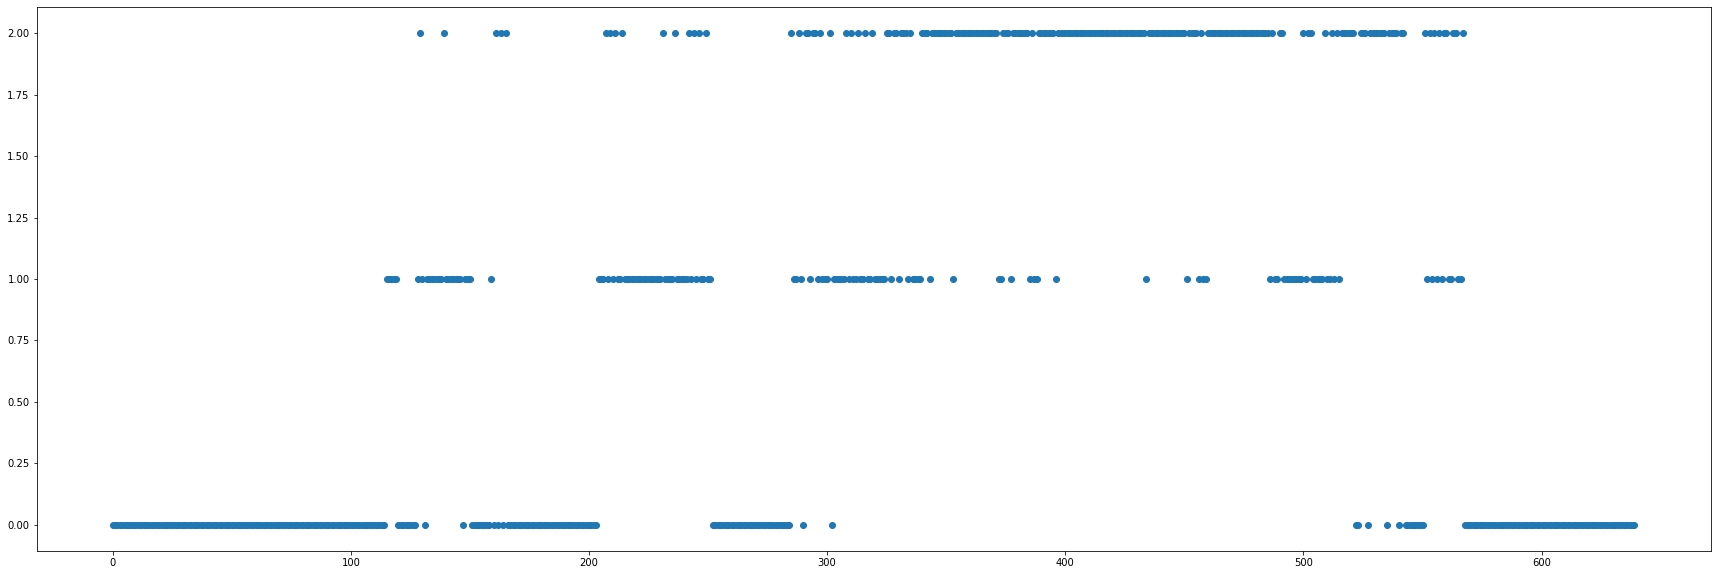

In [201]:
plt.figure(figsize=(30,10))
plt.scatter(list(range(len(y_pred_with_zeros_lr))), y_pred_with_zeros_lr);

In [204]:
make_video(y_pred_with_zeros_lr, 'LR')

Video has been successfully created!


### Обробка відео із NN

In [205]:
X_test_video, ids_nn, ids_for_zero_nn = create_X_for_nn(500, "video_frames")

print()
print("X_test_video shape:", X_test_video.shape)

175 : 1175.jpg hasn't got any features!
176 : 1176.jpg hasn't got any features!
177 : 1177.jpg hasn't got any features!
178 : 1178.jpg hasn't got any features!
183 : 1183.jpg hasn't got any features!
184 : 1184.jpg hasn't got any features!
185 : 1185.jpg hasn't got any features!
186 : 1186.jpg hasn't got any features!
187 : 1187.jpg hasn't got any features!
188 : 1188.jpg hasn't got any features!
189 : 1189.jpg hasn't got any features!
190 : 1190.jpg hasn't got any features!
191 : 1191.jpg hasn't got any features!
192 : 1192.jpg hasn't got any features!
193 : 1193.jpg hasn't got any features!
194 : 1194.jpg hasn't got any features!
195 : 1195.jpg hasn't got any features!
196 : 1196.jpg hasn't got any features!
197 : 1197.jpg hasn't got any features!
198 : 1198.jpg hasn't got any features!
199 : 1199.jpg hasn't got any features!
254 : 1254.jpg hasn't got any features!
255 : 1255.jpg hasn't got any features!
256 : 1256.jpg hasn't got any features!
257 : 1257.jpg hasn't got any features!


In [171]:
X_for_nn, y_for_nn = create_X_and_y_pca(500, directory_test)

print()
print("X_for_nn shape:", X_for_nn.shape)
print("y_for_nn shape:", y_for_nn.shape)

241.jpg hasn't got any features!
267.jpg hasn't got any features!
269.jpg hasn't got any features!
39.jpg hasn't got any features!
46.jpg hasn't got any features!
91.jpg hasn't got any features!
92.jpg hasn't got any features!
93.jpg hasn't got any features!

X_for_nn shape: (261, 32)
y_for_nn shape: (261,)


In [178]:
from sklearn.neural_network import MLPClassifier
nn = MLPClassifier(hidden_layer_sizes=(300,))

nn.fit(X_for_nn, y_for_nn)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(300,), learning_rate='constant',
              learning_rate_init=0.001, max_iter=200, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

In [179]:
y_pred_nn = nn.predict(X_test_video)

In [180]:
y_pred_nn

array([2, 0, 0, 2, 0, 2, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 0, 2,
       2, 0, 2, 2, 1, 1, 1, 2, 1, 2, 0, 0, 1, 0, 2, 0, 1, 0, 0, 0, 0, 0,
       0, 2, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 2, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 2, 1, 1, 1, 2, 1, 1, 2, 1, 2,
       2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 2, 1, 2, 2, 2, 0,
       0, 0, 2, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 2, 1, 0, 2, 2,
       2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2,

In [181]:
y_pred_with_zeros_nn = add_zeros(y_pred_nn, ids_nn, ids_for_zero_nn)

In [206]:
y_pred_with_zeros_nn

array([2, 0, 0, 2, 0, 2, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 0, 2,
       2, 0, 2, 2, 1, 1, 1, 2, 1, 2, 0, 0, 1, 0, 2, 0, 1, 0, 0, 0, 0, 0,
       0, 2, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 2, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 2, 1, 1, 1, 2, 1, 1, 2, 1, 2,
       2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 2, 1, 2, 2, 2, 0,
       0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

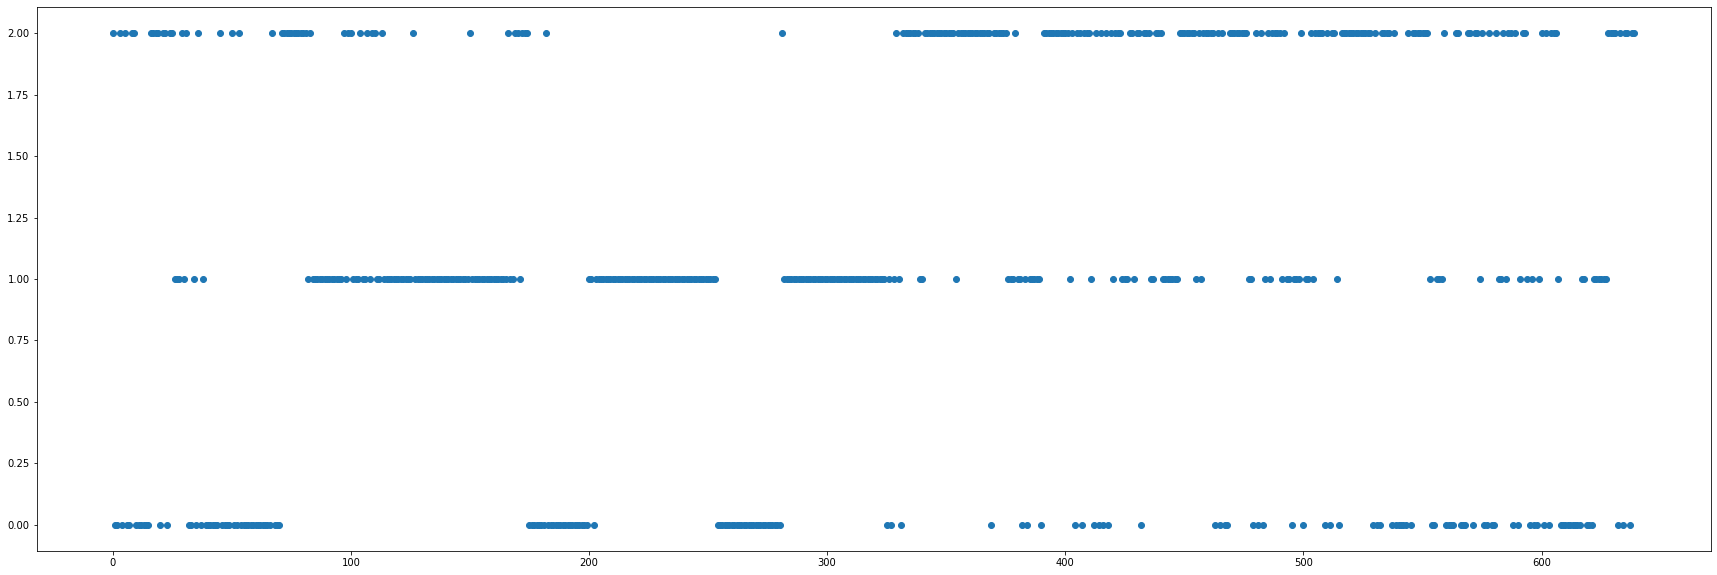

In [207]:
plt.figure(figsize=(30,10))
plt.scatter(list(range(len(y_pred_with_zeros_nn))), y_pred_with_zeros_nn);

In [208]:
make_video(y_pred_with_zeros_nn, 'NN')

Video has been successfully created!


## Відео з візуалізацією процесу розпізнавання

In [39]:
import cv2
import numpy as np

img = cv2.imread("main_photo.jpg", cv2.IMREAD_GRAYSCALE)  # queryiamge
img = cv2.resize(img, (480, 480))
cap = cv2.VideoCapture(0)

# Features
orb = cv2.ORB_create(1500)
kp_image, desc_image = orb.detectAndCompute(img, None)

# Feature matching
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

# For video recording
# fourcc = cv2.VideoWriter_fourcc(*'XVID')
# video_name = 'video_detection.avi'
# resolution = (1120, 480)
# out = cv2.VideoWriter(video_name, fourcc, 20.0, resolution, isColor=False)

while True:
    _, frame = cap.read()
    grayframe = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)  # trainimage
    kp_grayframe, desc_grayframe = orb.detectAndCompute(grayframe, None)
    
    matches = bf.match(desc_image, desc_grayframe)
    matches = sorted(matches, key = lambda x: x.distance)

    query_pts = np.float32([kp_image[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
    train_pts = np.float32([kp_grayframe[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)
    _, mask = cv2.findHomography(query_pts, train_pts, cv2.RANSAC, 5.0)
    matches_mask = mask.ravel().tolist()
    
    true_matches = []
    for index, el in enumerate(matches_mask):
        if el == 1:
            true_matches.append(matches[index])
    
    matching_true_relults = cv2.drawMatches(img, kp_image, grayframe, kp_grayframe, true_matches, None)

    # out.write(matching_true_relults)
    
    cv2.imshow("True Matches", matching_true_relults)
    
    key = cv2.waitKey(1)
    if key == 27:
        break

cap.release()
# out.release()
cv2.destroyAllWindows()

Не знаю, чи вдалося реалізувати те, що потрібно було, проте мені було досить цікаво написати такий код. У майбутньому його можна якось докрутити, щоб програма прорисовувала контури машинки на відео. Проте чомусь я не зміг записати відео через код у Пайтоні, дійсно дуже довго розбирався, але так і не вийшло, тому я записав роботу програми через запис екрану на Windows.